In [24]:
import pandas as pd
import math
import json
import requests
import os.path
import time
from binance.client import Client
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook
import glob

In [13]:
# API Keys
binance_api_key = "insert_here"
binance_api_secret = "insert_here"

In [15]:
# Constants
binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 750
binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)

In [14]:
#Functions
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime('1 Jan 2017', '%d %b %Y')
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    return old, new


In [32]:
def get_all_binance(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime('1 Jan 2022', '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, '2022-03-01', '2022-06-01')
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    data = data[["timestamp","close_time", "close"]].copy()
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

In [35]:
binance_symbols = ['BTCUSDT', 'LTCUSDT', 'ADAUSDT', 'DOTUSDT', 'ETHUSDT', 'MATICUSDT']
for symbol in binance_symbols:
    get_all_binance(symbol, '1h', save = True)

All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!


In [25]:
files = glob.glob('//*.csv')

In [59]:
data_list = []
for file in files:
    data = pd.read_csv(file)
    symbol = file.split('/')[-1].split('.')[0]
    symbol = symbol.split('/')[0]
    ss = data[['close']]
    ss = ss.rename(columns={"close":symbol})
    data_list.append(ss)

data_list.insert(0,data[["timestamp"]])
df = pd.concat(data_list, axis = 1)

In [45]:
print(symbol)

BTCUSDT-1h-data


In [66]:
df.set_index("timestamp", inplace = True)
df

,DOTUSDT-1h-data,ADAUSDT-1h-data,MATICUSDT-1h-data,LTCUSDT-1h-data,ETHUSDT-1h-data,BTCUSDT-1h-data
timestamp,,,,,,
2022-03-01 00:00:00,19.12,0.9770,1.637,114.6,2947.68,43560.00
2022-03-01 01:00:00,18.81,0.9670,1.611,112.9,2917.06,43259.90
2022-03-01 02:00:00,18.72,0.9720,1.604,112.8,2917.23,43160.01
2022-03-01 03:00:00,18.67,0.9670,1.585,112.5,2911.83,43147.71
2022-03-01 04:00:00,18.77,0.9660,1.595,113.0,2925.01,43336.26
...,...,...,...,...,...,...
2022-05-31 20:00:00,10.34,0.6038,0.663,68.5,1953.66,31813.65
2022-05-31 21:00:00,10.43,0.6133,0.659,68.3,1947.46,31720.01
2022-05-31 22:00:00,10.56,0.6399,0.666,69.0,1957.09,31869.28


In [72]:
df.columns = ["DOTUSDT", "ADAUSDT","MATICUSDT","LTCUSDT", "ETHUSDT","BTCUSDT"]

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2209 entries, 2022-03-01 00:00:00 to 2022-06-01 00:00:00
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DOTUSDT-1h-data    2209 non-null   float64
 1   ADAUSDT-1h-data    2209 non-null   float64
 2   MATICUSDT-1h-data  2209 non-null   float64
 3   LTCUSDT-1h-data    2209 non-null   float64
 4   ETHUSDT-1h-data    2209 non-null   float64
 5   BTCUSDT-1h-data    2209 non-null   float64
dtypes: float64(6)
memory usage: 120.8+ KB


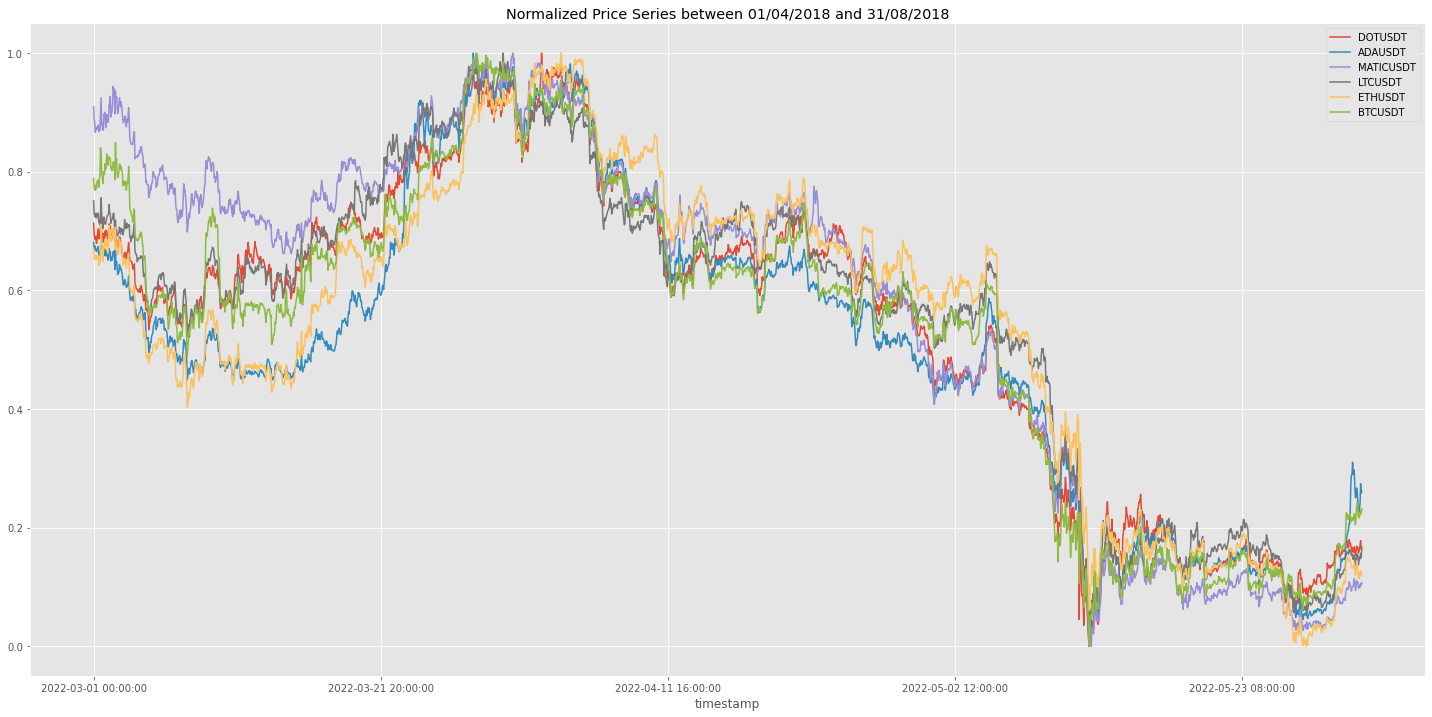

In [73]:
import matplotlib.pyplot as plt
normalized_df=(df-df.min())/(df.max()-df.min()) # normalize the price series
normalized_df.plot(figsize=(25,12), title='Normalized Price Series between 01/04/2018 and 31/08/2018'); # Plot


## ADF


In [74]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

t_results_table = pd.DataFrame(columns=binance_symbols, index=binance_symbols) # Initizalize empty datafrane with binance_symbols as both columns and indexes
p_results_table = pd.DataFrame(columns=binance_symbols, index=binance_symbols) # Initizalize empty datafrane with binance_symbols as both columns and indexes

# Loop every column and every row
for row in binance_symbols:
    for column in binance_symbols:
        # If column is the same as row then set NaN as the result of the ADF test
        if row == column: 
            t_results_table[column][row] = np.nan
            p_results_table[column][row] = np.nan
        else: 
            regression = sm.OLS(df[row], sm.add_constant(df[column])).fit().params # Apply OLS     
            residual = df[row]-regression[1]*df[column]-regression[0] # Build the residual price series
            adf_results = adfuller(residual) # Calculate the ADF test on the residuals
            t_results_table[column][row] = adf_results[0] # Save the results to table
            p_results_table[column][row] = adf_results[1] # Save the results to table
            

In [75]:
t_results_table.head(len(binance_symbols))

,BTCUSDT,LTCUSDT,ADAUSDT,DOTUSDT,ETHUSDT,MATICUSDT
BTCUSDT,NaN,-2.879033,-2.988406,-4.089696,-1.639399,-2.464889
LTCUSDT,-2.740668,NaN,-1.768647,-2.981688,-1.688586,-2.477473
ADAUSDT,-2.947494,-1.917807,NaN,-2.256929,-2.050389,-1.246107
DOTUSDT,-3.965984,-2.973311,-2.147117,NaN,-1.828497,-2.63178
ETHUSDT,-1.312788,-1.658887,-1.907308,-1.834397,NaN,-1.575507
MATICUSDT,-2.295179,-2.458856,-0.948733,-2.566273,-1.535631,NaN


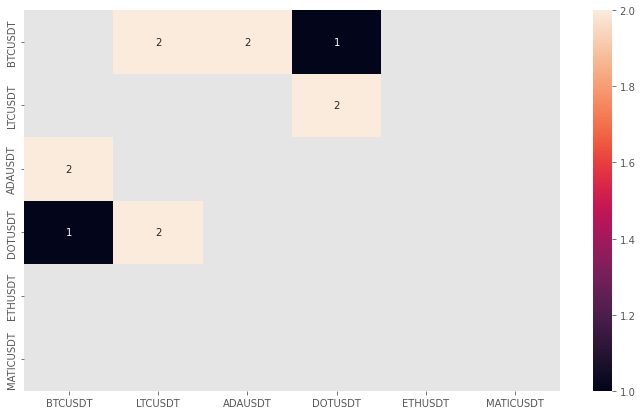

In [76]:
# Define function that gets a cell (value) and compares to critical values of the ADF test
def tstat(cell):
    if cell < adf_results[4]['1%']:
        ret = 1
    elif cell < adf_results[4]['5%']:
        ret = 2
    else:
        ret = np.nan
    return ret

def convp(cell):
    if cell < 0.05:
        ret = 1
    else:
        ret = np.nan
    return ret

# Apply tstat function to every cell on table
tstat_table = t_results_table.applymap(tstat)
pvalue_table = p_results_table.applymap(convp)

results_table = pd.DataFrame(tstat_table.values*pvalue_table.values, columns=tstat_table.columns, index=tstat_table.index)

# Plot results with Seaborn
import seaborn as sns
fig = plt.figure(figsize=(12,7))
ax = sns.heatmap(results_table.values.astype(float), xticklabels = tstat_table.columns, yticklabels = tstat_table.columns, annot = True)

<AxesSubplot:title={'center':'DOTUSDT - BTCUSDT'}, xlabel='timestamp'>

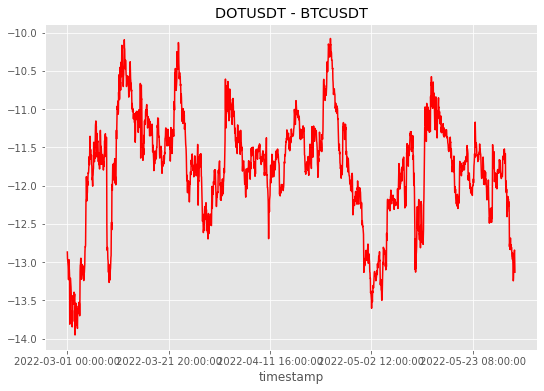

In [83]:
fig = plt.figure(figsize=(30,6))
ax1 = fig.add_subplot(131)
ax1.set_title('DOTUSDT - BTCUSDT')


regression = sm.OLS(df['DOTUSDT'], sm.add_constant(df['BTCUSDT'])).fit().params    
residual = df['DOTUSDT']-regression[1]*df['BTCUSDT']
residual.plot(ax=ax1, color='red')


In [85]:
first = ['DOTUSDT','BTCUSDT']
regression = sm.OLS(df['DOTUSDT'], sm.add_constant(df['BTCUSDT'])).fit().params    
first_series = df['DOTUSDT']-regression[1]*df['BTCUSDT']
title1 = (first[0] + ' - ' + str(np.around(regression[1], decimals=6)) + ' * ' + first[1])
first_df = pd.DataFrame(columns=[title1], index=df.index, data=first_series)

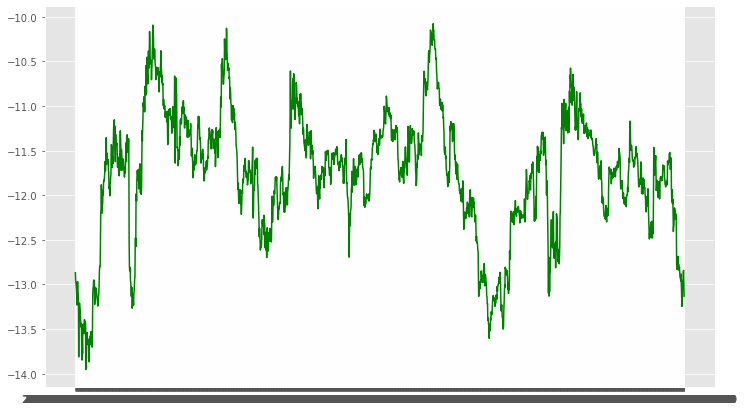

In [86]:
fig = plt.figure(figsize=(12,7))
plt.plot(first_df, color='green');

In [87]:
fir_adf = adfuller(first_series)
print('The Dickey-Fuller Test t-statistic is ' + str(np.around(fir_adf[0],4)) + ', which is smaller than the 1% critical value of ' + str(np.around(fir_adf[4]['1%'],4)))
print('The Dickey-Fuller Test p-value is ' + str(np.around(fir_adf[1],4)) + ', which is smaller than 0.05')


The Dickey-Fuller Test t-statistic is -3.966, which is smaller than the 1% critical value of -3.4333
The Dickey-Fuller Test p-value is 0.0016, which is smaller than 0.05
